In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)
n_points = 500
y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3))#,np.ones(n_points)*4,
                    #np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500


In [3]:
x = np.zeros((n_points*4,5))


np.random.seed(1)
cov_mat = [[0.001,0,0,0,0],[0,0.001,0,0,0],[0,0,0.001,0,0],
                                                 [0,0,0,0.001,0],[0,0,0,0,0.001]]

x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0],
                                            cov=cov_mat,size=sum(idx[0]))


x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0],
                                            cov=cov_mat,size=sum(idx[1]))


x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0],
                                            cov=cov_mat,size=sum(idx[2]))


x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5],
                                            cov=cov_mat,size=sum(idx[3]))



# x[idx[4],:] = np.random.multivariate_normal(mean = [0,0,0,0.65,-0.65],
#                                             cov=cov_mat,size=sum(idx[4]))


# x[idx[5],:] = np.random.multivariate_normal(mean = [0,0,0,-0.9,-0.75],
#                                             cov=cov_mat,size=sum(idx[5]))


# x[idx[6],:] = np.random.multivariate_normal(mean = [0,0,0,0.8,-0.8],
#                                             cov=cov_mat,size=sum(idx[6]))

# x[idx[7],:] = np.random.multivariate_normal(mean = [0,0,0,-0.5,0.8],
#                                             cov=cov_mat,size=sum(idx[7]))


# x[idx[8],:] = np.random.multivariate_normal(mean = [0,0,0,0.9,0.75],
#                                             cov=cov_mat,size=sum(idx[8]))


# x[idx[9],:] = np.random.multivariate_normal(mean = [0,0,0,-1,0.65],
#                                             cov=cov_mat,size=sum(idx[9]))

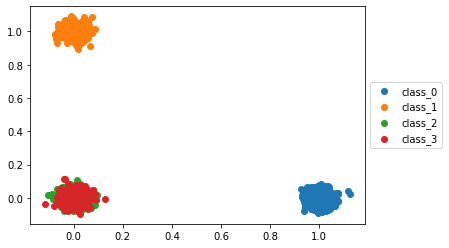

In [4]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

In [6]:
x

array([[ 1.8463458 , -0.6218591 , -0.61583906,  0.46563852, -0.4417109 ],
       [ 1.56041161, -0.45028337, -0.63283667,  0.60058985, -0.60267884],
       [ 1.83452955, -0.72731227, -0.60083129,  0.53242687, -0.4029609 ],
       ...,
       [-0.60631141, -0.54339609, -0.45873802, -1.79437768,  1.76573135],
       [-0.43492654, -0.58119668, -0.63612655, -1.76819303,  1.63392536],
       [-0.56983039, -0.54170839, -0.65128592, -1.73572432,  1.5087875 ]])

In [7]:
# for i in range(10):
#     plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# bg_idx = [ np.where(idx[3] == True)[0], 
#           np.where(idx[4] == True)[0], 
#           np.where(idx[5] == True)[0],
#           np.where(idx[6] == True)[0], 
#           np.where(idx[7] == True)[0], 
#           np.where(idx[8] == True)[0],
#           np.where(idx[9] == True)[0]]

# bg_idx = np.concatenate(bg_idx, axis = 0)
# bg_idx.shape

In [9]:
# np.unique(bg_idx).shape

In [10]:
# x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)

In [11]:
# np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

In [12]:
# x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [13]:
# np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

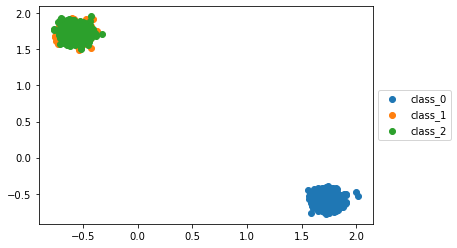

In [14]:
plt.scatter(x[idx[0],0],x[idx[0],1],label="class_"+str(0))
plt.scatter(x[idx[1],0],x[idx[1],1],label="class_"+str(1))
plt.scatter(x[idx[2],1],x[idx[2],2],label="class_"+str(2))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [15]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [16]:
desired_num = 1100  # 2000 + 1000


m = 100



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx =  0 #np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,5)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 496.10it/s]


In [17]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches dimension 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/500 , bg_image_ratio = (500-j)/499*500
  """
  avg_image_dataset = []
  for i in tqdm(range(len(mosaic_dataset))):
    img = torch.zeros([5], dtype=torch.float64)
    for j in range(m):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/(m)
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*(m))
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [18]:
tr = 100



avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 1,m)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 10,m)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 20,m)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 30,m )
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 40,m)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 50,m)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] ,60,m)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 70,m)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 80,m)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 80,m)
avg_image_dataset_11 , labels_11,  fg_index_11 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr], fore_idx[0:tr] , 100,m)
avg_image_dataset_12 , labels_12,  fg_index_12= create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr:], mosaic_label[tr:], fore_idx[tr:] , 100,m)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 292.80it/s]


In [19]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1,dim=0)
avg_image_dataset_2 = torch.stack(avg_image_dataset_2,dim=0)
avg_image_dataset_3 = torch.stack(avg_image_dataset_3,dim=0)
avg_image_dataset_4 = torch.stack(avg_image_dataset_4,dim=0)
avg_image_dataset_5 = torch.stack(avg_image_dataset_5,dim=0)
avg_image_dataset_6 = torch.stack(avg_image_dataset_6,dim=0)
avg_image_dataset_7 = torch.stack(avg_image_dataset_7,dim=0)
avg_image_dataset_8 = torch.stack(avg_image_dataset_8,dim=0)
avg_image_dataset_9 = torch.stack(avg_image_dataset_9,dim=0)
avg_image_dataset_10 = torch.stack(avg_image_dataset_10,dim=0)
avg_image_dataset_11 = torch.stack(avg_image_dataset_11,dim=0)
avg_image_dataset_12 = torch.stack(avg_image_dataset_12,dim=0)

In [20]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [21]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
trainloader_11 = DataLoader( traindata_11, batch_size= batch ,shuffle=True)



testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)


testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12)
testloader_12 = DataLoader( testdata_12 , batch_size= batch ,shuffle=False)



mosaicdata = MosaicDataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=True)


In [22]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(5, 3)
    torch.nn.init.zeros_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [23]:
torch.manual_seed(12)
net = Net()

In [24]:
for params in net.parameters():
    print(params)

Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


In [25]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 100
    
    loss = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data

            batch = inputs.size(0)
            #print(batch)
            patches = inputs.size(1)
            dims = inputs.size(2)
            
            
            data_weight = torch.ones((batch,patches,dims))*((1-alpha_)/(m-1))
            
            
            data_weight[:,0,:] = torch.ones((batch,dims))*alpha_
            
            
            #print(data_weight[0])
        
            
            data = torch.mul(data_weight,inputs)
            
            data_new = torch.zeros((batch,dims))
            for i in range(len(data)):
                data_new[i,:] = torch.sum(data[i],dim=0) 
            #print(data_new)
            outputs = net(data_new.double())
            loss_ = loss_criterion(outputs,target)
            loss.append(loss_.item())
    return np.mean(loss)

In [26]:
# torch.manual_seed(12)
# net = Net().double()
# net = net.to(device)
# criterion = nn.CrossEntropyLoss()
# calculate_loss_alpha(mosaicloader,0,net,criterion)

In [27]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)
         

In [28]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [29]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    loss_alpha_h_curi = []
    epochs = 1000
    
    
    criterion_ = nn.CrossEntropyLoss()
    if alpha == 1.0:
        print("alpha is", alpha)
        alpha_ = alpha
    else:
        alpha_ = alpha+0.01
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch ==0:
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 1
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    
    
    #torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [30]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12]

temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,10/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,20/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,30/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,40/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_6, 6, testloader_list,mosaicloader,50/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_7, 7, testloader_list,mosaicloader,60/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_8, 8, testloader_list,mosaicloader,70/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_9, 9, testloader_list,mosaicloader,80/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_10, 10, testloader_list,mosaicloader,90/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_11, 11, testloader_list,mosaicloader,100/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,     1] loss: 1.099
[2,     1] loss: 1.091
[3,     1] loss: 1.087
[4,     1] loss: 1.085
[5,     1] loss: 1.085
[6,     1] loss: 1.086
[7,     1] loss: 1.087
[8,     1] loss: 1.088
[9,     1] loss: 1.087
[10,     1] loss: 1.087
[11,     1] loss: 1.086
[12,     1] loss: 1.085
[13,     1] loss: 1.084
[14,     1] loss: 1.084
[15,     1] loss: 1.084
[16,     1] loss: 1.084
[17,     1] loss: 1.084
[18,     1] loss: 1.084
[19,     1] loss: 1.084
[20,     1] loss: 1.084
[21,     1] loss: 1.084
[22,     1] loss: 1.083
[23,     1] loss: 1.083
[24,     1] loss: 1.083
[25,     1] loss: 1.083
[26,     1] loss: 1.083
[27,     1] loss: 1.083
[28,     1] loss: 1.083
[29,     1] loss: 1.082
[30,     1] loss: 1.082
[31,     1] loss: 1.082
[32,     1] loss: 1.082
[33,     1] loss: 1.082
[34,     1] loss: 1.082
[35,     1] loss: 1.081
[36,     1] loss: 1.081
[37,     1] loss: 1.081
[38,     1] los

[352,     1] loss: 1.021
[353,     1] loss: 1.020
[354,     1] loss: 1.020
[355,     1] loss: 1.020
[356,     1] loss: 1.020
[357,     1] loss: 1.020
[358,     1] loss: 1.019
[359,     1] loss: 1.019
[360,     1] loss: 1.019
[361,     1] loss: 1.019
[362,     1] loss: 1.018
[363,     1] loss: 1.018
[364,     1] loss: 1.018
[365,     1] loss: 1.018
[366,     1] loss: 1.018
[367,     1] loss: 1.017
[368,     1] loss: 1.017
[369,     1] loss: 1.017
[370,     1] loss: 1.017
[371,     1] loss: 1.017
[372,     1] loss: 1.016
[373,     1] loss: 1.016
[374,     1] loss: 1.016
[375,     1] loss: 1.016
[376,     1] loss: 1.015
[377,     1] loss: 1.015
[378,     1] loss: 1.015
[379,     1] loss: 1.015
[380,     1] loss: 1.015
[381,     1] loss: 1.014
[382,     1] loss: 1.014
[383,     1] loss: 1.014
[384,     1] loss: 1.014
[385,     1] loss: 1.014
[386,     1] loss: 1.013
[387,     1] loss: 1.013
[388,     1] loss: 1.013
[389,     1] loss: 1.013
[390,     1] loss: 1.012
[391,     1] loss: 1.012


[729,     1] loss: 0.939
[730,     1] loss: 0.938
[731,     1] loss: 0.938
[732,     1] loss: 0.938
[733,     1] loss: 0.938
[734,     1] loss: 0.938
[735,     1] loss: 0.937
[736,     1] loss: 0.937
[737,     1] loss: 0.937
[738,     1] loss: 0.937
[739,     1] loss: 0.937
[740,     1] loss: 0.936
[741,     1] loss: 0.936
[742,     1] loss: 0.936
[743,     1] loss: 0.936
[744,     1] loss: 0.935
[745,     1] loss: 0.935
[746,     1] loss: 0.935
[747,     1] loss: 0.935
[748,     1] loss: 0.935
[749,     1] loss: 0.934
[750,     1] loss: 0.934
[751,     1] loss: 0.934
[752,     1] loss: 0.934
[753,     1] loss: 0.933
[754,     1] loss: 0.933
[755,     1] loss: 0.933
[756,     1] loss: 0.933
[757,     1] loss: 0.933
[758,     1] loss: 0.932
[759,     1] loss: 0.932
[760,     1] loss: 0.932
[761,     1] loss: 0.932
[762,     1] loss: 0.932
[763,     1] loss: 0.931
[764,     1] loss: 0.931
[765,     1] loss: 0.931
[766,     1] loss: 0.931
[767,     1] loss: 0.930
[768,     1] loss: 0.930


[23,     1] loss: 1.026
[24,     1] loss: 1.024
[25,     1] loss: 1.021
[26,     1] loss: 1.018
[27,     1] loss: 1.015
[28,     1] loss: 1.012
[29,     1] loss: 1.009
[30,     1] loss: 1.007
[31,     1] loss: 1.004
[32,     1] loss: 1.001
[33,     1] loss: 0.998
[34,     1] loss: 0.996
[35,     1] loss: 0.993
[36,     1] loss: 0.990
[37,     1] loss: 0.987
[38,     1] loss: 0.985
[39,     1] loss: 0.982
[40,     1] loss: 0.979
[41,     1] loss: 0.977
[42,     1] loss: 0.974
[43,     1] loss: 0.971
[44,     1] loss: 0.968
[45,     1] loss: 0.966
[46,     1] loss: 0.963
[47,     1] loss: 0.960
[48,     1] loss: 0.958
[49,     1] loss: 0.955
[50,     1] loss: 0.952
[51,     1] loss: 0.950
[52,     1] loss: 0.947
[53,     1] loss: 0.944
[54,     1] loss: 0.942
[55,     1] loss: 0.939
[56,     1] loss: 0.937
[57,     1] loss: 0.934
[58,     1] loss: 0.931
[59,     1] loss: 0.929
[60,     1] loss: 0.926
[61,     1] loss: 0.923
[62,     1] loss: 0.921
[63,     1] loss: 0.918
[64,     1] loss

[384,     1] loss: 0.379
[385,     1] loss: 0.378
[386,     1] loss: 0.377
[387,     1] loss: 0.376
[388,     1] loss: 0.375
[389,     1] loss: 0.374
[390,     1] loss: 0.373
[391,     1] loss: 0.372
[392,     1] loss: 0.371
[393,     1] loss: 0.370
[394,     1] loss: 0.369
[395,     1] loss: 0.369
[396,     1] loss: 0.368
[397,     1] loss: 0.367
[398,     1] loss: 0.366
[399,     1] loss: 0.365
[400,     1] loss: 0.364
[401,     1] loss: 0.363
[402,     1] loss: 0.362
[403,     1] loss: 0.361
[404,     1] loss: 0.360
[405,     1] loss: 0.359
[406,     1] loss: 0.359
[407,     1] loss: 0.358
[408,     1] loss: 0.357
[409,     1] loss: 0.356
[410,     1] loss: 0.355
[411,     1] loss: 0.354
[412,     1] loss: 0.353
[413,     1] loss: 0.352
[414,     1] loss: 0.351
[415,     1] loss: 0.351
[416,     1] loss: 0.350
[417,     1] loss: 0.349
[418,     1] loss: 0.348
[419,     1] loss: 0.347
[420,     1] loss: 0.346
[421,     1] loss: 0.345
[422,     1] loss: 0.345
[423,     1] loss: 0.344


[721,     1] loss: 0.180
[722,     1] loss: 0.179
[723,     1] loss: 0.179
[724,     1] loss: 0.179
[725,     1] loss: 0.178
[726,     1] loss: 0.178
[727,     1] loss: 0.178
[728,     1] loss: 0.177
[729,     1] loss: 0.177
[730,     1] loss: 0.177
[731,     1] loss: 0.176
[732,     1] loss: 0.176
[733,     1] loss: 0.176
[734,     1] loss: 0.175
[735,     1] loss: 0.175
[736,     1] loss: 0.175
[737,     1] loss: 0.174
[738,     1] loss: 0.174
[739,     1] loss: 0.174
[740,     1] loss: 0.173
[741,     1] loss: 0.173
[742,     1] loss: 0.173
[743,     1] loss: 0.172
[744,     1] loss: 0.172
[745,     1] loss: 0.172
[746,     1] loss: 0.171
[747,     1] loss: 0.171
[748,     1] loss: 0.171
[749,     1] loss: 0.170
[750,     1] loss: 0.170
[751,     1] loss: 0.170
[752,     1] loss: 0.169
[753,     1] loss: 0.169
[754,     1] loss: 0.169
[755,     1] loss: 0.168
[756,     1] loss: 0.168
[757,     1] loss: 0.168
[758,     1] loss: 0.168
[759,     1] loss: 0.167
[760,     1] loss: 0.167


[35,     1] loss: 0.895
[36,     1] loss: 0.889
[37,     1] loss: 0.884
[38,     1] loss: 0.879
[39,     1] loss: 0.874
[40,     1] loss: 0.869
[41,     1] loss: 0.864
[42,     1] loss: 0.859
[43,     1] loss: 0.854
[44,     1] loss: 0.849
[45,     1] loss: 0.844
[46,     1] loss: 0.839
[47,     1] loss: 0.834
[48,     1] loss: 0.829
[49,     1] loss: 0.824
[50,     1] loss: 0.820
[51,     1] loss: 0.815
[52,     1] loss: 0.810
[53,     1] loss: 0.805
[54,     1] loss: 0.801
[55,     1] loss: 0.796
[56,     1] loss: 0.791
[57,     1] loss: 0.787
[58,     1] loss: 0.782
[59,     1] loss: 0.778
[60,     1] loss: 0.773
[61,     1] loss: 0.768
[62,     1] loss: 0.764
[63,     1] loss: 0.759
[64,     1] loss: 0.755
[65,     1] loss: 0.751
[66,     1] loss: 0.746
[67,     1] loss: 0.742
[68,     1] loss: 0.738
[69,     1] loss: 0.733
[70,     1] loss: 0.729
[71,     1] loss: 0.725
[72,     1] loss: 0.720
[73,     1] loss: 0.716
[74,     1] loss: 0.712
[75,     1] loss: 0.708
[76,     1] loss

[366,     1] loss: 0.172
[367,     1] loss: 0.172
[368,     1] loss: 0.171
[369,     1] loss: 0.170
[370,     1] loss: 0.170
[371,     1] loss: 0.169
[372,     1] loss: 0.169
[373,     1] loss: 0.168
[374,     1] loss: 0.167
[375,     1] loss: 0.167
[376,     1] loss: 0.166
[377,     1] loss: 0.165
[378,     1] loss: 0.165
[379,     1] loss: 0.164
[380,     1] loss: 0.164
[381,     1] loss: 0.163
[382,     1] loss: 0.162
[383,     1] loss: 0.162
[384,     1] loss: 0.161
[385,     1] loss: 0.161
[386,     1] loss: 0.160
[387,     1] loss: 0.160
[388,     1] loss: 0.159
[389,     1] loss: 0.158
[390,     1] loss: 0.158
[391,     1] loss: 0.157
[392,     1] loss: 0.157
[393,     1] loss: 0.156
[394,     1] loss: 0.156
[395,     1] loss: 0.155
[396,     1] loss: 0.155
[397,     1] loss: 0.154
[398,     1] loss: 0.153
[399,     1] loss: 0.153
[400,     1] loss: 0.152
[401,     1] loss: 0.152
[402,     1] loss: 0.151
[403,     1] loss: 0.151
[404,     1] loss: 0.150
[405,     1] loss: 0.150


[700,     1] loss: 0.066
[701,     1] loss: 0.066
[702,     1] loss: 0.066
[703,     1] loss: 0.066
[704,     1] loss: 0.065
[705,     1] loss: 0.065
[706,     1] loss: 0.065
[707,     1] loss: 0.065
[708,     1] loss: 0.065
[709,     1] loss: 0.065
[710,     1] loss: 0.065
[711,     1] loss: 0.064
[712,     1] loss: 0.064
[713,     1] loss: 0.064
[714,     1] loss: 0.064
[715,     1] loss: 0.064
[716,     1] loss: 0.064
[717,     1] loss: 0.064
[718,     1] loss: 0.063
[719,     1] loss: 0.063
[720,     1] loss: 0.063
[721,     1] loss: 0.063
[722,     1] loss: 0.063
[723,     1] loss: 0.063
[724,     1] loss: 0.063
[725,     1] loss: 0.063
[726,     1] loss: 0.062
[727,     1] loss: 0.062
[728,     1] loss: 0.062
[729,     1] loss: 0.062
[730,     1] loss: 0.062
[731,     1] loss: 0.062
[732,     1] loss: 0.062
[733,     1] loss: 0.061
[734,     1] loss: 0.061
[735,     1] loss: 0.061
[736,     1] loss: 0.061
[737,     1] loss: 0.061
[738,     1] loss: 0.061
[739,     1] loss: 0.061


[12,     1] loss: 0.990
[13,     1] loss: 0.981
[14,     1] loss: 0.973
[15,     1] loss: 0.965
[16,     1] loss: 0.956
[17,     1] loss: 0.948
[18,     1] loss: 0.939
[19,     1] loss: 0.931
[20,     1] loss: 0.922
[21,     1] loss: 0.914
[22,     1] loss: 0.906
[23,     1] loss: 0.898
[24,     1] loss: 0.890
[25,     1] loss: 0.882
[26,     1] loss: 0.875
[27,     1] loss: 0.867
[28,     1] loss: 0.859
[29,     1] loss: 0.852
[30,     1] loss: 0.844
[31,     1] loss: 0.837
[32,     1] loss: 0.829
[33,     1] loss: 0.822
[34,     1] loss: 0.815
[35,     1] loss: 0.807
[36,     1] loss: 0.800
[37,     1] loss: 0.793
[38,     1] loss: 0.786
[39,     1] loss: 0.779
[40,     1] loss: 0.772
[41,     1] loss: 0.765
[42,     1] loss: 0.758
[43,     1] loss: 0.752
[44,     1] loss: 0.745
[45,     1] loss: 0.738
[46,     1] loss: 0.732
[47,     1] loss: 0.725
[48,     1] loss: 0.719
[49,     1] loss: 0.712
[50,     1] loss: 0.706
[51,     1] loss: 0.700
[52,     1] loss: 0.693
[53,     1] loss

[397,     1] loss: 0.084
[398,     1] loss: 0.084
[399,     1] loss: 0.083
[400,     1] loss: 0.083
[401,     1] loss: 0.083
[402,     1] loss: 0.082
[403,     1] loss: 0.082
[404,     1] loss: 0.082
[405,     1] loss: 0.082
[406,     1] loss: 0.081
[407,     1] loss: 0.081
[408,     1] loss: 0.081
[409,     1] loss: 0.080
[410,     1] loss: 0.080
[411,     1] loss: 0.080
[412,     1] loss: 0.079
[413,     1] loss: 0.079
[414,     1] loss: 0.079
[415,     1] loss: 0.079
[416,     1] loss: 0.078
[417,     1] loss: 0.078
[418,     1] loss: 0.078
[419,     1] loss: 0.077
[420,     1] loss: 0.077
[421,     1] loss: 0.077
[422,     1] loss: 0.077
[423,     1] loss: 0.076
[424,     1] loss: 0.076
[425,     1] loss: 0.076
[426,     1] loss: 0.076
[427,     1] loss: 0.075
[428,     1] loss: 0.075
[429,     1] loss: 0.075
[430,     1] loss: 0.075
[431,     1] loss: 0.074
[432,     1] loss: 0.074
[433,     1] loss: 0.074
[434,     1] loss: 0.073
[435,     1] loss: 0.073
[436,     1] loss: 0.073


[735,     1] loss: 0.032
[736,     1] loss: 0.032
[737,     1] loss: 0.032
[738,     1] loss: 0.032
[739,     1] loss: 0.032
[740,     1] loss: 0.032
[741,     1] loss: 0.032
[742,     1] loss: 0.032
[743,     1] loss: 0.032
[744,     1] loss: 0.032
[745,     1] loss: 0.031
[746,     1] loss: 0.031
[747,     1] loss: 0.031
[748,     1] loss: 0.031
[749,     1] loss: 0.031
[750,     1] loss: 0.031
[751,     1] loss: 0.031
[752,     1] loss: 0.031
[753,     1] loss: 0.031
[754,     1] loss: 0.031
[755,     1] loss: 0.031
[756,     1] loss: 0.031
[757,     1] loss: 0.031
[758,     1] loss: 0.031
[759,     1] loss: 0.031
[760,     1] loss: 0.030
[761,     1] loss: 0.030
[762,     1] loss: 0.030
[763,     1] loss: 0.030
[764,     1] loss: 0.030
[765,     1] loss: 0.030
[766,     1] loss: 0.030
[767,     1] loss: 0.030
[768,     1] loss: 0.030
[769,     1] loss: 0.030
[770,     1] loss: 0.030
[771,     1] loss: 0.030
[772,     1] loss: 0.030
[773,     1] loss: 0.030
[774,     1] loss: 0.030


[44,     1] loss: 0.652
[45,     1] loss: 0.644
[46,     1] loss: 0.637
[47,     1] loss: 0.629
[48,     1] loss: 0.622
[49,     1] loss: 0.614
[50,     1] loss: 0.607
[51,     1] loss: 0.600
[52,     1] loss: 0.592
[53,     1] loss: 0.585
[54,     1] loss: 0.578
[55,     1] loss: 0.572
[56,     1] loss: 0.565
[57,     1] loss: 0.558
[58,     1] loss: 0.551
[59,     1] loss: 0.545
[60,     1] loss: 0.539
[61,     1] loss: 0.532
[62,     1] loss: 0.526
[63,     1] loss: 0.520
[64,     1] loss: 0.514
[65,     1] loss: 0.508
[66,     1] loss: 0.502
[67,     1] loss: 0.496
[68,     1] loss: 0.490
[69,     1] loss: 0.485
[70,     1] loss: 0.479
[71,     1] loss: 0.474
[72,     1] loss: 0.468
[73,     1] loss: 0.463
[74,     1] loss: 0.458
[75,     1] loss: 0.453
[76,     1] loss: 0.448
[77,     1] loss: 0.442
[78,     1] loss: 0.438
[79,     1] loss: 0.433
[80,     1] loss: 0.428
[81,     1] loss: 0.423
[82,     1] loss: 0.418
[83,     1] loss: 0.414
[84,     1] loss: 0.409
[85,     1] loss

[433,     1] loss: 0.047
[434,     1] loss: 0.047
[435,     1] loss: 0.047
[436,     1] loss: 0.046
[437,     1] loss: 0.046
[438,     1] loss: 0.046
[439,     1] loss: 0.046
[440,     1] loss: 0.046
[441,     1] loss: 0.046
[442,     1] loss: 0.045
[443,     1] loss: 0.045
[444,     1] loss: 0.045
[445,     1] loss: 0.045
[446,     1] loss: 0.045
[447,     1] loss: 0.045
[448,     1] loss: 0.045
[449,     1] loss: 0.044
[450,     1] loss: 0.044
[451,     1] loss: 0.044
[452,     1] loss: 0.044
[453,     1] loss: 0.044
[454,     1] loss: 0.044
[455,     1] loss: 0.043
[456,     1] loss: 0.043
[457,     1] loss: 0.043
[458,     1] loss: 0.043
[459,     1] loss: 0.043
[460,     1] loss: 0.043
[461,     1] loss: 0.043
[462,     1] loss: 0.042
[463,     1] loss: 0.042
[464,     1] loss: 0.042
[465,     1] loss: 0.042
[466,     1] loss: 0.042
[467,     1] loss: 0.042
[468,     1] loss: 0.042
[469,     1] loss: 0.041
[470,     1] loss: 0.041
[471,     1] loss: 0.041
[472,     1] loss: 0.041


[828,     1] loss: 0.017
[829,     1] loss: 0.017
[830,     1] loss: 0.017
[831,     1] loss: 0.017
[832,     1] loss: 0.017
[833,     1] loss: 0.017
[834,     1] loss: 0.017
[835,     1] loss: 0.017
[836,     1] loss: 0.017
[837,     1] loss: 0.016
[838,     1] loss: 0.016
[839,     1] loss: 0.016
[840,     1] loss: 0.016
[841,     1] loss: 0.016
[842,     1] loss: 0.016
[843,     1] loss: 0.016
[844,     1] loss: 0.016
[845,     1] loss: 0.016
[846,     1] loss: 0.016
[847,     1] loss: 0.016
[848,     1] loss: 0.016
[849,     1] loss: 0.016
[850,     1] loss: 0.016
[851,     1] loss: 0.016
[852,     1] loss: 0.016
[853,     1] loss: 0.016
[854,     1] loss: 0.016
[855,     1] loss: 0.016
[856,     1] loss: 0.016
[857,     1] loss: 0.016
[858,     1] loss: 0.016
[859,     1] loss: 0.016
[860,     1] loss: 0.016
[861,     1] loss: 0.016
[862,     1] loss: 0.016
[863,     1] loss: 0.016
[864,     1] loss: 0.016
[865,     1] loss: 0.016
[866,     1] loss: 0.016
[867,     1] loss: 0.016


[149,     1] loss: 0.159
[150,     1] loss: 0.157
[151,     1] loss: 0.156
[152,     1] loss: 0.154
[153,     1] loss: 0.153
[154,     1] loss: 0.152
[155,     1] loss: 0.150
[156,     1] loss: 0.149
[157,     1] loss: 0.148
[158,     1] loss: 0.146
[159,     1] loss: 0.145
[160,     1] loss: 0.144
[161,     1] loss: 0.143
[162,     1] loss: 0.141
[163,     1] loss: 0.140
[164,     1] loss: 0.139
[165,     1] loss: 0.138
[166,     1] loss: 0.137
[167,     1] loss: 0.136
[168,     1] loss: 0.134
[169,     1] loss: 0.133
[170,     1] loss: 0.132
[171,     1] loss: 0.131
[172,     1] loss: 0.130
[173,     1] loss: 0.129
[174,     1] loss: 0.128
[175,     1] loss: 0.127
[176,     1] loss: 0.126
[177,     1] loss: 0.125
[178,     1] loss: 0.124
[179,     1] loss: 0.123
[180,     1] loss: 0.122
[181,     1] loss: 0.121
[182,     1] loss: 0.120
[183,     1] loss: 0.119
[184,     1] loss: 0.118
[185,     1] loss: 0.117
[186,     1] loss: 0.116
[187,     1] loss: 0.116
[188,     1] loss: 0.115


[533,     1] loss: 0.024
[534,     1] loss: 0.024
[535,     1] loss: 0.024
[536,     1] loss: 0.024
[537,     1] loss: 0.024
[538,     1] loss: 0.023
[539,     1] loss: 0.023
[540,     1] loss: 0.023
[541,     1] loss: 0.023
[542,     1] loss: 0.023
[543,     1] loss: 0.023
[544,     1] loss: 0.023
[545,     1] loss: 0.023
[546,     1] loss: 0.023
[547,     1] loss: 0.023
[548,     1] loss: 0.023
[549,     1] loss: 0.023
[550,     1] loss: 0.023
[551,     1] loss: 0.023
[552,     1] loss: 0.023
[553,     1] loss: 0.022
[554,     1] loss: 0.022
[555,     1] loss: 0.022
[556,     1] loss: 0.022
[557,     1] loss: 0.022
[558,     1] loss: 0.022
[559,     1] loss: 0.022
[560,     1] loss: 0.022
[561,     1] loss: 0.022
[562,     1] loss: 0.022
[563,     1] loss: 0.022
[564,     1] loss: 0.022
[565,     1] loss: 0.022
[566,     1] loss: 0.022
[567,     1] loss: 0.022
[568,     1] loss: 0.022
[569,     1] loss: 0.022
[570,     1] loss: 0.021
[571,     1] loss: 0.021
[572,     1] loss: 0.021


[914,     1] loss: 0.010
[915,     1] loss: 0.010
[916,     1] loss: 0.010
[917,     1] loss: 0.010
[918,     1] loss: 0.010
[919,     1] loss: 0.010
[920,     1] loss: 0.010
[921,     1] loss: 0.010
[922,     1] loss: 0.010
[923,     1] loss: 0.010
[924,     1] loss: 0.010
[925,     1] loss: 0.010
[926,     1] loss: 0.010
[927,     1] loss: 0.010
[928,     1] loss: 0.010
[929,     1] loss: 0.010
[930,     1] loss: 0.010
[931,     1] loss: 0.010
[932,     1] loss: 0.010
[933,     1] loss: 0.010
[934,     1] loss: 0.010
[935,     1] loss: 0.010
[936,     1] loss: 0.010
[937,     1] loss: 0.010
[938,     1] loss: 0.010
[939,     1] loss: 0.010
[940,     1] loss: 0.010
[941,     1] loss: 0.010
[942,     1] loss: 0.010
[943,     1] loss: 0.010
[944,     1] loss: 0.010
[945,     1] loss: 0.010
[946,     1] loss: 0.009
[947,     1] loss: 0.009
[948,     1] loss: 0.009
[949,     1] loss: 0.009
[950,     1] loss: 0.009
[951,     1] loss: 0.009
[952,     1] loss: 0.009
[953,     1] loss: 0.009


[228,     1] loss: 0.065
[229,     1] loss: 0.065
[230,     1] loss: 0.064
[231,     1] loss: 0.064
[232,     1] loss: 0.063
[233,     1] loss: 0.063
[234,     1] loss: 0.063
[235,     1] loss: 0.062
[236,     1] loss: 0.062
[237,     1] loss: 0.062
[238,     1] loss: 0.061
[239,     1] loss: 0.061
[240,     1] loss: 0.060
[241,     1] loss: 0.060
[242,     1] loss: 0.060
[243,     1] loss: 0.059
[244,     1] loss: 0.059
[245,     1] loss: 0.059
[246,     1] loss: 0.058
[247,     1] loss: 0.058
[248,     1] loss: 0.057
[249,     1] loss: 0.057
[250,     1] loss: 0.057
[251,     1] loss: 0.056
[252,     1] loss: 0.056
[253,     1] loss: 0.056
[254,     1] loss: 0.055
[255,     1] loss: 0.055
[256,     1] loss: 0.055
[257,     1] loss: 0.055
[258,     1] loss: 0.054
[259,     1] loss: 0.054
[260,     1] loss: 0.054
[261,     1] loss: 0.053
[262,     1] loss: 0.053
[263,     1] loss: 0.053
[264,     1] loss: 0.052
[265,     1] loss: 0.052
[266,     1] loss: 0.052
[267,     1] loss: 0.051


[559,     1] loss: 0.017
[560,     1] loss: 0.017
[561,     1] loss: 0.016
[562,     1] loss: 0.016
[563,     1] loss: 0.016
[564,     1] loss: 0.016
[565,     1] loss: 0.016
[566,     1] loss: 0.016
[567,     1] loss: 0.016
[568,     1] loss: 0.016
[569,     1] loss: 0.016
[570,     1] loss: 0.016
[571,     1] loss: 0.016
[572,     1] loss: 0.016
[573,     1] loss: 0.016
[574,     1] loss: 0.016
[575,     1] loss: 0.016
[576,     1] loss: 0.016
[577,     1] loss: 0.016
[578,     1] loss: 0.016
[579,     1] loss: 0.016
[580,     1] loss: 0.016
[581,     1] loss: 0.016
[582,     1] loss: 0.016
[583,     1] loss: 0.016
[584,     1] loss: 0.015
[585,     1] loss: 0.015
[586,     1] loss: 0.015
[587,     1] loss: 0.015
[588,     1] loss: 0.015
[589,     1] loss: 0.015
[590,     1] loss: 0.015
[591,     1] loss: 0.015
[592,     1] loss: 0.015
[593,     1] loss: 0.015
[594,     1] loss: 0.015
[595,     1] loss: 0.015
[596,     1] loss: 0.015
[597,     1] loss: 0.015
[598,     1] loss: 0.015


[949,     1] loss: 0.007
[950,     1] loss: 0.007
[951,     1] loss: 0.007
[952,     1] loss: 0.007
[953,     1] loss: 0.007
[954,     1] loss: 0.007
[955,     1] loss: 0.007
[956,     1] loss: 0.007
[957,     1] loss: 0.007
[958,     1] loss: 0.007
[959,     1] loss: 0.007
[960,     1] loss: 0.007
[961,     1] loss: 0.007
[962,     1] loss: 0.007
[963,     1] loss: 0.007
[964,     1] loss: 0.007
[965,     1] loss: 0.007
[966,     1] loss: 0.007
[967,     1] loss: 0.007
[968,     1] loss: 0.007
[969,     1] loss: 0.007
[970,     1] loss: 0.007
[971,     1] loss: 0.007
[972,     1] loss: 0.007
[973,     1] loss: 0.007
[974,     1] loss: 0.007
[975,     1] loss: 0.007
[976,     1] loss: 0.007
[977,     1] loss: 0.007
[978,     1] loss: 0.007
[979,     1] loss: 0.007
[980,     1] loss: 0.007
[981,     1] loss: 0.007
[982,     1] loss: 0.007
[983,     1] loss: 0.007
[984,     1] loss: 0.007
[985,     1] loss: 0.007
[986,     1] loss: 0.007
[987,     1] loss: 0.007
[988,     1] loss: 0.007


[257,     1] loss: 0.043
[258,     1] loss: 0.042
[259,     1] loss: 0.042
[260,     1] loss: 0.042
[261,     1] loss: 0.042
[262,     1] loss: 0.041
[263,     1] loss: 0.041
[264,     1] loss: 0.041
[265,     1] loss: 0.041
[266,     1] loss: 0.041
[267,     1] loss: 0.040
[268,     1] loss: 0.040
[269,     1] loss: 0.040
[270,     1] loss: 0.040
[271,     1] loss: 0.039
[272,     1] loss: 0.039
[273,     1] loss: 0.039
[274,     1] loss: 0.039
[275,     1] loss: 0.039
[276,     1] loss: 0.038
[277,     1] loss: 0.038
[278,     1] loss: 0.038
[279,     1] loss: 0.038
[280,     1] loss: 0.038
[281,     1] loss: 0.037
[282,     1] loss: 0.037
[283,     1] loss: 0.037
[284,     1] loss: 0.037
[285,     1] loss: 0.037
[286,     1] loss: 0.036
[287,     1] loss: 0.036
[288,     1] loss: 0.036
[289,     1] loss: 0.036
[290,     1] loss: 0.036
[291,     1] loss: 0.035
[292,     1] loss: 0.035
[293,     1] loss: 0.035
[294,     1] loss: 0.035
[295,     1] loss: 0.035
[296,     1] loss: 0.035


[586,     1] loss: 0.012
[587,     1] loss: 0.012
[588,     1] loss: 0.012
[589,     1] loss: 0.012
[590,     1] loss: 0.012
[591,     1] loss: 0.012
[592,     1] loss: 0.012
[593,     1] loss: 0.012
[594,     1] loss: 0.012
[595,     1] loss: 0.012
[596,     1] loss: 0.012
[597,     1] loss: 0.012
[598,     1] loss: 0.012
[599,     1] loss: 0.012
[600,     1] loss: 0.012
[601,     1] loss: 0.012
[602,     1] loss: 0.012
[603,     1] loss: 0.012
[604,     1] loss: 0.012
[605,     1] loss: 0.011
[606,     1] loss: 0.011
[607,     1] loss: 0.011
[608,     1] loss: 0.011
[609,     1] loss: 0.011
[610,     1] loss: 0.011
[611,     1] loss: 0.011
[612,     1] loss: 0.011
[613,     1] loss: 0.011
[614,     1] loss: 0.011
[615,     1] loss: 0.011
[616,     1] loss: 0.011
[617,     1] loss: 0.011
[618,     1] loss: 0.011
[619,     1] loss: 0.011
[620,     1] loss: 0.011
[621,     1] loss: 0.011
[622,     1] loss: 0.011
[623,     1] loss: 0.011
[624,     1] loss: 0.011
[625,     1] loss: 0.011


[975,     1] loss: 0.005
[976,     1] loss: 0.005
[977,     1] loss: 0.005
[978,     1] loss: 0.005
[979,     1] loss: 0.005
[980,     1] loss: 0.005
[981,     1] loss: 0.005
[982,     1] loss: 0.005
[983,     1] loss: 0.005
[984,     1] loss: 0.005
[985,     1] loss: 0.005
[986,     1] loss: 0.005
[987,     1] loss: 0.005
[988,     1] loss: 0.005
[989,     1] loss: 0.005
[990,     1] loss: 0.005
[991,     1] loss: 0.005
[992,     1] loss: 0.005
[993,     1] loss: 0.005
[994,     1] loss: 0.005
[995,     1] loss: 0.005
[996,     1] loss: 0.005
[997,     1] loss: 0.005
[998,     1] loss: 0.005
[999,     1] loss: 0.005
[1000,     1] loss: 0.005
Finished Training
Accuracy of the network on the train images: 100 %
Accuracy of the network on the test dataset 1: 35 %
Accuracy of the network on the test dataset 2: 74 %
Accuracy of the network on the test dataset 3: 100 %
Accuracy of the network on the test dataset 4: 100 %
Accuracy of the network on the test dataset 5: 100 %
Accuracy of the n

[282,     1] loss: 0.030
[283,     1] loss: 0.030
[284,     1] loss: 0.030
[285,     1] loss: 0.030
[286,     1] loss: 0.029
[287,     1] loss: 0.029
[288,     1] loss: 0.029
[289,     1] loss: 0.029
[290,     1] loss: 0.029
[291,     1] loss: 0.029
[292,     1] loss: 0.028
[293,     1] loss: 0.028
[294,     1] loss: 0.028
[295,     1] loss: 0.028
[296,     1] loss: 0.028
[297,     1] loss: 0.028
[298,     1] loss: 0.028
[299,     1] loss: 0.027
[300,     1] loss: 0.027
[301,     1] loss: 0.027
[302,     1] loss: 0.027
[303,     1] loss: 0.027
[304,     1] loss: 0.027
[305,     1] loss: 0.027
[306,     1] loss: 0.027
[307,     1] loss: 0.026
[308,     1] loss: 0.026
[309,     1] loss: 0.026
[310,     1] loss: 0.026
[311,     1] loss: 0.026
[312,     1] loss: 0.026
[313,     1] loss: 0.026
[314,     1] loss: 0.026
[315,     1] loss: 0.025
[316,     1] loss: 0.025
[317,     1] loss: 0.025
[318,     1] loss: 0.025
[319,     1] loss: 0.025
[320,     1] loss: 0.025
[321,     1] loss: 0.025


[615,     1] loss: 0.009
[616,     1] loss: 0.009
[617,     1] loss: 0.009
[618,     1] loss: 0.009
[619,     1] loss: 0.009
[620,     1] loss: 0.009
[621,     1] loss: 0.009
[622,     1] loss: 0.009
[623,     1] loss: 0.009
[624,     1] loss: 0.009
[625,     1] loss: 0.009
[626,     1] loss: 0.009
[627,     1] loss: 0.009
[628,     1] loss: 0.009
[629,     1] loss: 0.009
[630,     1] loss: 0.009
[631,     1] loss: 0.009
[632,     1] loss: 0.009
[633,     1] loss: 0.009
[634,     1] loss: 0.009
[635,     1] loss: 0.009
[636,     1] loss: 0.009
[637,     1] loss: 0.009
[638,     1] loss: 0.009
[639,     1] loss: 0.009
[640,     1] loss: 0.009
[641,     1] loss: 0.009
[642,     1] loss: 0.008
[643,     1] loss: 0.008
[644,     1] loss: 0.008
[645,     1] loss: 0.008
[646,     1] loss: 0.008
[647,     1] loss: 0.008
[648,     1] loss: 0.008
[649,     1] loss: 0.008
[650,     1] loss: 0.008
[651,     1] loss: 0.008
[652,     1] loss: 0.008
[653,     1] loss: 0.008
[654,     1] loss: 0.008


[943,     1] loss: 0.005
[944,     1] loss: 0.005
[945,     1] loss: 0.005
[946,     1] loss: 0.005
[947,     1] loss: 0.005
[948,     1] loss: 0.005
[949,     1] loss: 0.005
[950,     1] loss: 0.005
[951,     1] loss: 0.005
[952,     1] loss: 0.005
[953,     1] loss: 0.004
[954,     1] loss: 0.004
[955,     1] loss: 0.004
[956,     1] loss: 0.004
[957,     1] loss: 0.004
[958,     1] loss: 0.004
[959,     1] loss: 0.004
[960,     1] loss: 0.004
[961,     1] loss: 0.004
[962,     1] loss: 0.004
[963,     1] loss: 0.004
[964,     1] loss: 0.004
[965,     1] loss: 0.004
[966,     1] loss: 0.004
[967,     1] loss: 0.004
[968,     1] loss: 0.004
[969,     1] loss: 0.004
[970,     1] loss: 0.004
[971,     1] loss: 0.004
[972,     1] loss: 0.004
[973,     1] loss: 0.004
[974,     1] loss: 0.004
[975,     1] loss: 0.004
[976,     1] loss: 0.004
[977,     1] loss: 0.004
[978,     1] loss: 0.004
[979,     1] loss: 0.004
[980,     1] loss: 0.004
[981,     1] loss: 0.004
[982,     1] loss: 0.004


[248,     1] loss: 0.036
[249,     1] loss: 0.036
[250,     1] loss: 0.036
[251,     1] loss: 0.036
[252,     1] loss: 0.035
[253,     1] loss: 0.035
[254,     1] loss: 0.035
[255,     1] loss: 0.035
[256,     1] loss: 0.035
[257,     1] loss: 0.034
[258,     1] loss: 0.034
[259,     1] loss: 0.034
[260,     1] loss: 0.034
[261,     1] loss: 0.034
[262,     1] loss: 0.033
[263,     1] loss: 0.033
[264,     1] loss: 0.033
[265,     1] loss: 0.033
[266,     1] loss: 0.033
[267,     1] loss: 0.033
[268,     1] loss: 0.032
[269,     1] loss: 0.032
[270,     1] loss: 0.032
[271,     1] loss: 0.032
[272,     1] loss: 0.032
[273,     1] loss: 0.031
[274,     1] loss: 0.031
[275,     1] loss: 0.031
[276,     1] loss: 0.031
[277,     1] loss: 0.031
[278,     1] loss: 0.031
[279,     1] loss: 0.030
[280,     1] loss: 0.030
[281,     1] loss: 0.030
[282,     1] loss: 0.030
[283,     1] loss: 0.030
[284,     1] loss: 0.030
[285,     1] loss: 0.030
[286,     1] loss: 0.029
[287,     1] loss: 0.029


[642,     1] loss: 0.008
[643,     1] loss: 0.008
[644,     1] loss: 0.008
[645,     1] loss: 0.008
[646,     1] loss: 0.008
[647,     1] loss: 0.008
[648,     1] loss: 0.008
[649,     1] loss: 0.008
[650,     1] loss: 0.008
[651,     1] loss: 0.008
[652,     1] loss: 0.008
[653,     1] loss: 0.008
[654,     1] loss: 0.008
[655,     1] loss: 0.008
[656,     1] loss: 0.008
[657,     1] loss: 0.008
[658,     1] loss: 0.008
[659,     1] loss: 0.008
[660,     1] loss: 0.008
[661,     1] loss: 0.008
[662,     1] loss: 0.008
[663,     1] loss: 0.008
[664,     1] loss: 0.008
[665,     1] loss: 0.008
[666,     1] loss: 0.008
[667,     1] loss: 0.008
[668,     1] loss: 0.008
[669,     1] loss: 0.008
[670,     1] loss: 0.008
[671,     1] loss: 0.008
[672,     1] loss: 0.008
[673,     1] loss: 0.008
[674,     1] loss: 0.008
[675,     1] loss: 0.008
[676,     1] loss: 0.008
[677,     1] loss: 0.008
[678,     1] loss: 0.008
[679,     1] loss: 0.008
[680,     1] loss: 0.008
[681,     1] loss: 0.008


[27,     1] loss: 0.488
[28,     1] loss: 0.473
[29,     1] loss: 0.458
[30,     1] loss: 0.444
[31,     1] loss: 0.430
[32,     1] loss: 0.417
[33,     1] loss: 0.404
[34,     1] loss: 0.392
[35,     1] loss: 0.380
[36,     1] loss: 0.369
[37,     1] loss: 0.358
[38,     1] loss: 0.348
[39,     1] loss: 0.338
[40,     1] loss: 0.328
[41,     1] loss: 0.318
[42,     1] loss: 0.309
[43,     1] loss: 0.301
[44,     1] loss: 0.292
[45,     1] loss: 0.284
[46,     1] loss: 0.277
[47,     1] loss: 0.269
[48,     1] loss: 0.262
[49,     1] loss: 0.255
[50,     1] loss: 0.249
[51,     1] loss: 0.242
[52,     1] loss: 0.236
[53,     1] loss: 0.230
[54,     1] loss: 0.225
[55,     1] loss: 0.219
[56,     1] loss: 0.214
[57,     1] loss: 0.209
[58,     1] loss: 0.204
[59,     1] loss: 0.199
[60,     1] loss: 0.195
[61,     1] loss: 0.190
[62,     1] loss: 0.186
[63,     1] loss: 0.182
[64,     1] loss: 0.178
[65,     1] loss: 0.174
[66,     1] loss: 0.171
[67,     1] loss: 0.167
[68,     1] loss

[368,     1] loss: 0.014
[369,     1] loss: 0.014
[370,     1] loss: 0.014
[371,     1] loss: 0.014
[372,     1] loss: 0.014
[373,     1] loss: 0.014
[374,     1] loss: 0.014
[375,     1] loss: 0.014
[376,     1] loss: 0.014
[377,     1] loss: 0.014
[378,     1] loss: 0.014
[379,     1] loss: 0.013
[380,     1] loss: 0.013
[381,     1] loss: 0.013
[382,     1] loss: 0.013
[383,     1] loss: 0.013
[384,     1] loss: 0.013
[385,     1] loss: 0.013
[386,     1] loss: 0.013
[387,     1] loss: 0.013
[388,     1] loss: 0.013
[389,     1] loss: 0.013
[390,     1] loss: 0.013
[391,     1] loss: 0.013
[392,     1] loss: 0.013
[393,     1] loss: 0.013
[394,     1] loss: 0.013
[395,     1] loss: 0.013
[396,     1] loss: 0.013
[397,     1] loss: 0.013
[398,     1] loss: 0.012
[399,     1] loss: 0.012
[400,     1] loss: 0.012
[401,     1] loss: 0.012
[402,     1] loss: 0.012
[403,     1] loss: 0.012
[404,     1] loss: 0.012
[405,     1] loss: 0.012
[406,     1] loss: 0.012
[407,     1] loss: 0.012


[757,     1] loss: 0.005
[758,     1] loss: 0.005
[759,     1] loss: 0.005
[760,     1] loss: 0.005
[761,     1] loss: 0.005
[762,     1] loss: 0.005
[763,     1] loss: 0.005
[764,     1] loss: 0.005
[765,     1] loss: 0.005
[766,     1] loss: 0.005
[767,     1] loss: 0.005
[768,     1] loss: 0.004
[769,     1] loss: 0.004
[770,     1] loss: 0.004
[771,     1] loss: 0.004
[772,     1] loss: 0.004
[773,     1] loss: 0.004
[774,     1] loss: 0.004
[775,     1] loss: 0.004
[776,     1] loss: 0.004
[777,     1] loss: 0.004
[778,     1] loss: 0.004
[779,     1] loss: 0.004
[780,     1] loss: 0.004
[781,     1] loss: 0.004
[782,     1] loss: 0.004
[783,     1] loss: 0.004
[784,     1] loss: 0.004
[785,     1] loss: 0.004
[786,     1] loss: 0.004
[787,     1] loss: 0.004
[788,     1] loss: 0.004
[789,     1] loss: 0.004
[790,     1] loss: 0.004
[791,     1] loss: 0.004
[792,     1] loss: 0.004
[793,     1] loss: 0.004
[794,     1] loss: 0.004
[795,     1] loss: 0.004
[796,     1] loss: 0.004


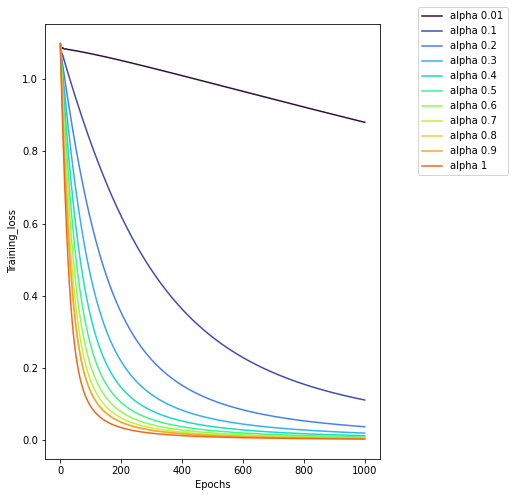

In [31]:
alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="alpha "+str(alpha[i]),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

Text(0.5, 1.0, 'alpha_=alpha+0.01')

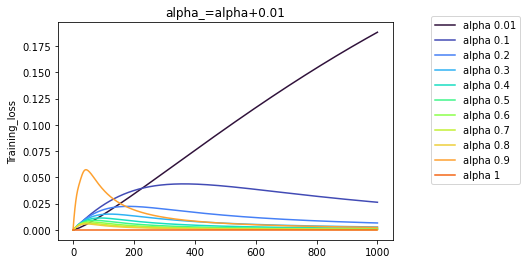

In [32]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="alpha "+str(alpha[i]),color = cm(i*20))
    plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("alpha_=alpha+0.01")

In [33]:
# np.array(train_loss_all[9]) - np.array(train_loss_alpha_h_all[9])

In [34]:
train_loss_alpha_h_all[0]

[1.0986122886681093,
 1.091378363109221,
 1.0871187551386778,
 1.0851103016795307,
 1.0847716778453778,
 1.0854936035361096,
 1.0864497918463,
 1.0869454007170425,
 1.0867537587156,
 1.0860368596172072,
 1.0850888792306068,
 1.0841600988295468,
 1.0834046139927933,
 1.0829008564404805,
 1.0826681976316546,
 1.0826601094293338,
 1.0827637044833445,
 1.0828315712436198,
 1.082744128098263,
 1.0824611455054387,
 1.082023529885409,
 1.08151538139329,
 1.0810198376392952,
 1.0805921720957163,
 1.0802554059563712,
 1.0800068127200404,
 1.0798224611234675,
 1.0796611409082002,
 1.0794759578574769,
 1.0792333546310722,
 1.0789278741384702,
 1.0785813008227572,
 1.0782274142541968,
 1.0778943931479865,
 1.0775957663653042,
 1.0773310701329673,
 1.0770900765066778,
 1.0768562151324015,
 1.0766104139287977,
 1.0763376117133416,
 1.0760337227148649,
 1.0757074787110257,
 1.0753748449053975,
 1.075050122975258,
 1.074740092387251,
 1.0744438434034802,
 1.0741559036345147,
 1.0738691728487813,
 1.07

In [35]:
train_loss_all[0]

[1.0986122886681093,
 1.091315841082698,
 1.087096659631471,
 1.0851905369841397,
 1.0849829180537958,
 1.0858525774876568,
 1.0869564201078483,
 1.087581754229019,
 1.087494733655339,
 1.0868616649134466,
 1.0859853714079744,
 1.0851233650610717,
 1.0844343747300054,
 1.0840005847373384,
 1.0838451837112841,
 1.0839247425676128,
 1.0841275897240077,
 1.0843052569382214,
 1.0843358002336536,
 1.084176981070705,
 1.0838688567008423,
 1.083495375980924,
 1.0831393204159425,
 1.0828549396197258,
 1.082663787767073,
 1.0825616667497053,
 1.082523301227924,
 1.082506165036142,
 1.0824621357587696,
 1.0823568672068877,
 1.082184922042656,
 1.0819689339086365,
 1.0817439926218795,
 1.08153960539038,
 1.0813704440708896,
 1.0812370410635535,
 1.0811300667442183,
 1.081033664671886,
 1.0809291515187476,
 1.0808014930500578,
 1.0806463673581597,
 1.0804721161214181,
 1.0802941695551478,
 1.0801261044428687,
 1.079973817699137,
 1.0798355125530894,
 1.079705003057217,
 1.0795747395776059,
 1.0794